In [1]:
from dotenv import load_dotenv, find_dotenv

_= load_dotenv(find_dotenv())

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.sqlite import SqliteSaver
import dill


In [5]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged



In [6]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages] # Reduce is introduced in order to replace messages if they have same id

In [7]:
tool = TavilySearchResults(max_results=2)

## Manual human approval

In [8]:
class Agent:
    def __init__(self, model, tools, system="", checkpointer=None):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges("llm", self.exists_action, {True: "action", False: END})
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def exists_action(self, state: AgentState):
        print(state)
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [ ]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""
with SqliteSaver.from_conn_string("memory.sqlite") as memory:
    print("Memory initialized")
   

In [ ]:
 model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)
messages = [HumanMessage(content="Whats the weather in Kigali?")]
thread = {"configurable": {"thread_id": "1"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
print(abot.graph.get_state(thread))
print(abot.graph.get_state(thread).next) # this will show that we are about to run an action, in order to continue let's pass None

for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)
print(abot.graph.get_state(thread))
print(abot.graph.get_state(thread).next)

In [ ]:
with SqliteSaver.from_conn_string("mydb.sqlite") as memory:
    print("Database initalized")

In [15]:
model = ChatOpenAI(model="gpt-3.5-turbo")
abot = Agent(model, [tool], system=prompt, checkpointer=memory)

In [ ]:
### continue after interrupt
with SqliteSaver.from_conn_string(":memory:") as memory:
    model = ChatOpenAI(model="gpt-3.5-turbo")
    abot = Agent(model, [tool], system=prompt, checkpointer=memory)
    messages = [HumanMessage(content="Whats the weather in Kigali?")]
    thread = {"configurable": {"thread_id": "2"}}
    for event in abot.graph.stream({"messages": messages}, thread):
        for v in event.values():
            print(v)
    print(abot.graph.get_state(thread))
    print(abot.graph.get_state(thread).next) # this will show that we are about to run an action, in order to continue let's pass None

    while abot.graph.get_state(thread).next:
        print("\n", abot.graph.get_state(thread),"\n")
        #_input = input("proceed?") # this line is supposed to trigger a prompt where I type yes but it's not working in vs code notebook
        _input = "y" # we are entering it manual and the above line was crashing the script
        if _input != "y":
            print("aborting")
            break
        for event in abot.graph.stream(None, thread):
            for v in event.values():
                print(v)

# State Memory

g.get_state(thread)
g.get_state_history(thread) this allows time travel to existing state and use it as current state and even update it




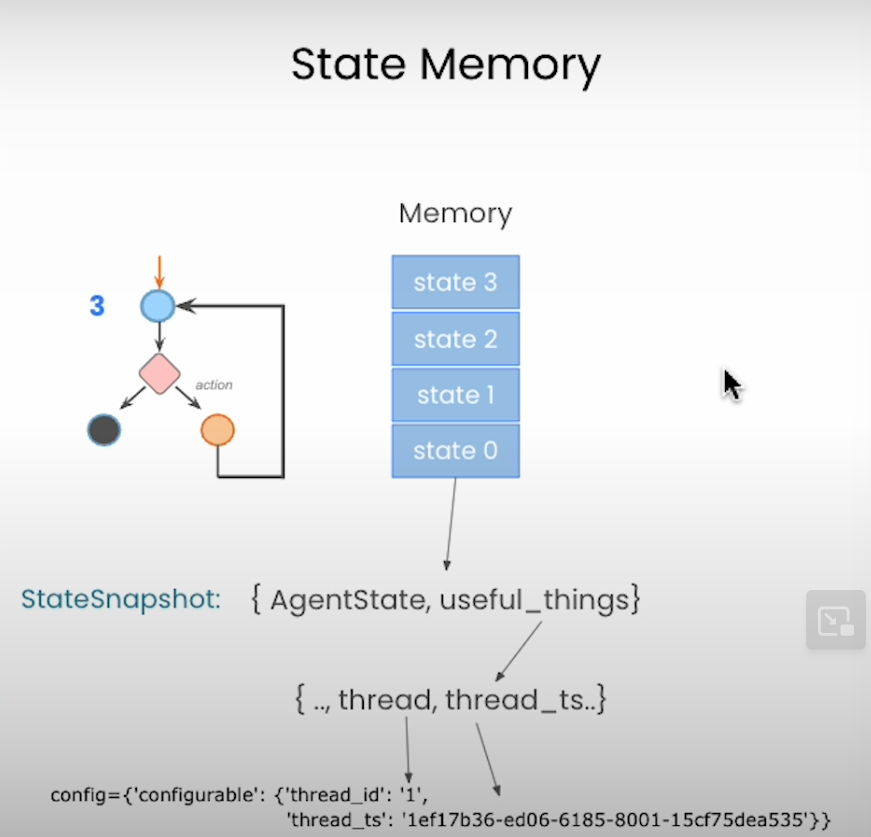